# BERTScore Scoring Against NIST and Wikipedia

Duplicating CrisisFACTS 2022 assessment via BERTScore

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import json
import glob
import gzip
import torch

import scipy.stats

import matplotlib.pyplot as plt

In [3]:
import wikipedia

In [4]:
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text.bert import BERTScore

c:\Users\VG User\Documents\GitHub\crisisfact\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get CrisisFACTS Event Metadata

In [5]:
event_df = pd.read_json("CrisisFACTs-2022to2023.topics.json", lines=False).set_index("eventID")

### Get Summaries from Wikipedia

In [6]:
def get_wiki_summary(url):
    
    if "wikipedia.org" not in url:
        return ""
    
    page_title = url.rpartition("/")[-1]
    print(url)
    page = wikipedia.page(title=page_title, auto_suggest=False)
    
    return page.summary

event_df["wiki.summary"] = event_df["url"].apply(get_wiki_summary)

https://en.wikipedia.org/wiki/Lilac_Fire
https://en.wikipedia.org/wiki/Cranston_Fire
https://en.wikipedia.org/wiki/Holy_Fire_(2018)
https://en.wikipedia.org/wiki/Hurricane_Florence
https://en.wikipedia.org/wiki/2018_Maryland_flood
https://en.wikipedia.org/wiki/Saddleridge_Fire
https://en.wikipedia.org/wiki/Hurricane_Laura
https://en.wikipedia.org/wiki/Hurricane_Sally
https://en.wikipedia.org/wiki/2020_Beirut_explosion
https://en.wikipedia.org/wiki/2020_Houston_explosion
https://en.wikipedia.org/wiki/Edenville_Dam#Dam_failure
https://en.wikipedia.org/wiki/Hurricane_Dorian
https://en.wikipedia.org/wiki/Kincade_Fire
https://en.wikipedia.org/wiki/2020_Easter_tornado_outbreak
https://en.wikipedia.org/wiki/Tornado_outbreak_of_April_22-23,_2020
https://en.wikipedia.org/wiki/Tornado_outbreak_of_March_2-3,_2020


### Get Summaries from Assessors

In [7]:
with open("final-annotated-facts-results.json", "r") as in_file:
    annotation_data = json.load(in_file)

In [8]:
event_fact_lists = {}

for req_id,req_data in annotation_data.items():
    event_id = req_id.rpartition("-")[0]
    local_fact_set = {f[0] for f in req_data["fact_list"] if f[2] == "USEFUL_FACT"}
    
    with open("../00-createSummaries/collapsed-event-days/Collapsed-%s.json" % req_id) as in_file:
        local_fact_data = json.load(in_file)
        
    local_fact_text = [
        fact["fact_text"] for fact in local_fact_data 
        if fact["collapsed_fact_id"] in local_fact_set
    ]
    
    local_fact_list = event_fact_lists.get(event_id, [])
    local_fact_list = local_fact_list + local_fact_text
    event_fact_lists[event_id] = local_fact_list

In [9]:
event_df["nist.summary"] = [". ".join(event_fact_lists[event_id]).replace("..", ".") for event_id in event_df.index]


In [10]:
# save on file and convert all to ascii on a txt
with open("nist_summary.txt", "w") as out_file:
    out_file.write(event_df["nist.summary"].iloc[0].encode("ascii", "ignore").decode("ascii"))


## Save the Summaries

In [11]:
event_df.to_json("CrisisFACTs-2022to2023.topics.withSummaries.json")

In [12]:
# event_df = pd.read_json("CrisisFACTs-2022to2023.topics.withSummaries_smaller.json", lines=False)

In [13]:
# # save on file and convert all to ascii on a txt
# with open("nist_summary_2.txt", "w") as out_file:
#     out_file.write(event_df["nist.summary"].iloc[0].encode("ascii", "ignore").decode("ascii"))

In [14]:
# rouge = ROUGEScore(
#     use_stemmer=True,
# )

import bert_score
bert_score.__version__

'0.3.12'

In [15]:
TOP_K = 32

In [16]:
all_req_ids = list(annotation_data.keys())

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [18]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of GPUs
print(torch.cuda.get_device_name(0))  # Should print your GPU name
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

True
1
NVIDIA GeForce RTX 3060
cuda


In [19]:
bert_model = "distilbert-base-uncased"
# bert_model = "microsoft/deberta-xlarge-mnli"
# bert_model = "microsoft/deberta-base-mnli"
# bert_model = "google/mt5-small"

In [20]:
bert_scorer = bert_score.BERTScorer(model_type=bert_model, device=device, batch_size=1, nthreads=1)

In [21]:
max_length = 200_000

In [22]:
submission_metrics = {}

for f in glob.glob("submissions/*.gz"):
    
    this_run_id = f.partition("\\")[-1].replace(".gz", "")
    print(f, "-->", this_run_id)
    
    this_run_event_request_facts = {k:[] for k in all_req_ids}
    with gzip.open(f, "r") as in_file:
        for line_ in in_file:
            line = line_.decode("utf8")
            
            entry = json.loads(line)
            this_req_id = entry["requestID"]
            
            # We skip days where we have no relevant facts from assessors
            if this_req_id not in all_req_ids:
                continue
            
            this_run_event_request_facts[this_req_id].append(entry)
            
    local_event_summaries = {e_id:[] for e_id in event_df.index}
    for event_request,this_fact_list in this_run_event_request_facts.items():
        event_id = event_request.rpartition("-")[0]
        
        sorted_fact_list = sorted(this_fact_list, key=lambda v: v["importance"], reverse=True)
        this_day_summary = [this_top_fact["factText"] for this_top_fact in sorted_fact_list[:TOP_K]]
        
        local_event_summaries[event_id] = local_event_summaries[event_id] + this_day_summary
        

    wiki_dfs = []
    nist_dfs = []
    for event_id,event in event_df.iterrows():
        
        this_submitted_summary = local_event_summaries[event_id]

        this_summary_text = ". ".join(this_submitted_summary).replace("..", ".")[:max_length]
        if len(this_summary_text) == 0:
            continue
        
        nist_summary = event["nist.summary"][:max_length]
        wiki_summary = event["wiki.summary"]
        
        print(f"event {event_id} - nist: {len(nist_summary)} - submitted: {len(this_summary_text)}")
        
        try:
            with torch.no_grad():
                # with torch.amp.autocast(device_type=device, dtype=torch.bfloat16):
                    nist_scores = bert_scorer.score([this_summary_text], [nist_summary])
                    wiki_scores = bert_scorer.score([this_summary_text], [wiki_summary])
            
        except torch.cuda.OutOfMemoryError:
            print("CUDA OOM")
            torch.cuda.empty_cache()
            continue
        except Exception as e:
            print(f"Error: {e}")
            continue
        
        nist_metric = {k: v.cpu().float().item() for k, v in zip(["precision", "recall", "f1"], nist_scores)}
        wiki_metric = {k: v.cpu().float().item() for k, v in zip(["precision", "recall", "f1"], wiki_scores)}
        
        # nist_metric = {
        #     "f1": nist_metric_[2],
        #     "precision": nist_metric_[0],
        #     "recall": nist_metric_[1],
        # }
        
        # wiki_metric = {
        #     "f1": wiki_metric_[2],
        #     "precision": wiki_metric_[0],
        #     "recall": wiki_metric_[1],
        # }
        
        this_wiki_df = pd.DataFrame([{"metric": k, "value": v, "event": event_id} for k, v in wiki_metric.items()])
        this_nist_df = pd.DataFrame([{"metric": k, "value": v, "event": event_id} for k, v in nist_metric.items()])
        
        display(this_nist_df)
        
        wiki_dfs.append(this_wiki_df)
        nist_dfs.append(this_nist_df)
        
    full_wiki_df = pd.concat(wiki_dfs)
    full_nist_df = pd.concat(nist_dfs)
    
    submission_metrics[this_run_id] = {
        "wiki": full_wiki_df,
        "nist": full_nist_df,
    }
    
    display(full_nist_df.groupby("metric")["value"].mean())



submissions\Thesis_Retriver.gz --> Thesis_Retriver
event CrisisFACTS-010 - nist: 19107 - submitted: 34018


,metric,value,event
0,precision,0.717312,CrisisFACTS-010
1,recall,0.768497,CrisisFACTS-010
2,f1,0.742023,CrisisFACTS-010


event CrisisFACTS-011 - nist: 12232 - submitted: 18335


,metric,value,event
0,precision,0.786624,CrisisFACTS-011
1,recall,0.771731,CrisisFACTS-011
2,f1,0.779106,CrisisFACTS-011


event CrisisFACTS-015 - nist: 54206 - submitted: 115150


,metric,value,event
0,precision,0.801710,CrisisFACTS-015
1,recall,0.779995,CrisisFACTS-015
2,f1,0.790704,CrisisFACTS-015


event CrisisFACTS-017 - nist: 52359 - submitted: 65781


,metric,value,event
0,precision,0.784863,CrisisFACTS-017
1,recall,0.823462,CrisisFACTS-017
2,f1,0.803700,CrisisFACTS-017


event CrisisFACTS-018 - nist: 76726 - submitted: 72239


,metric,value,event
0,precision,0.830871,CrisisFACTS-018
1,recall,0.831677,CrisisFACTS-018
2,f1,0.831274,CrisisFACTS-018


metric
f1           0.789361
precision    0.784276
recall       0.795073
Name: value, dtype: float64

In [23]:
all_runs = []
for k,v in submission_metrics.items():
    print(k)
    
    stackable = []
    for comparator,ldf in v.items():
        stackable_ldf = ldf.copy()
        stackable_ldf["target.summary"] = comparator

        stackable.append(stackable_ldf)

    this_run_df = pd.concat(stackable)
    this_run_df["run"] = k
    
    all_runs.append(this_run_df)
    this_run_df.to_csv("evaluation.output.bertscore/%s.csv" % k, index=False)
    
all_runs_df = pd.concat(all_runs)
all_runs_df.to_csv("evaluation.output.bertscore/all_runs.csv", index=False)

Thesis_Retriver


In [24]:
target_summaries = {}
for target in ["wiki", "nist"]:
    this_target_df = all_runs_df[all_runs_df["target.summary"] == target]
    
    index = []
    rows = []
    for run_name,group in this_target_df.groupby("run"):
        print(run_name)
        # this_row = group.pivot("event", "metric", "value").mean()
        this_row = group.pivot(index="event", columns="metric", values="value").mean()
        rows.append(this_row)
        index.append(run_name)

    summary_df = pd.DataFrame(rows, index=index)[[
        "f1", 
    ]]

    final_df = summary_df.sort_values(by="f1", ascending=False)
    final_df.to_csv("evaluation.output.bertscore/%s.summary.csv" % target)
    
    target_summaries[target] = final_df

Thesis_Retriver
Thesis_Retriver


In [25]:
rel2023_events = [
    'CrisisFACTS-009',
    'CrisisFACTS-010',
    'CrisisFACTS-011',
    'CrisisFACTS-012',
    'CrisisFACTS-013',
    'CrisisFACTS-014',
    'CrisisFACTS-015',
    'CrisisFACTS-016',
    'CrisisFACTS-017',
    'CrisisFACTS-018'

]

In [26]:
rows = []
for runtag,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("run"):
    print(runtag)
    t_map = {"run": runtag}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)

Thesis_Retriver
	 nist
		 f1 0.7893612265586853
		 precision 0.784276008605957
		 recall 0.7950725793838501
	 wiki
		 f1 0.7101886868476868
		 precision 0.6744513809680939
		 recall 0.7504524737596512


In [27]:
by_run_df = pd.DataFrame(rows).set_index("run")
by_run_df.to_csv("by_run.bertscore.summary.csv")
by_run_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
run,,
Thesis_Retriver,0.789361,0.710189


In [28]:
by_run_df[["nist.f1", "wiki.f1"]].corr()

,nist.f1,wiki.f1
nist.f1,NaN,NaN
wiki.f1,NaN,NaN


<Axes: xlabel='nist.f1', ylabel='wiki.f1'>

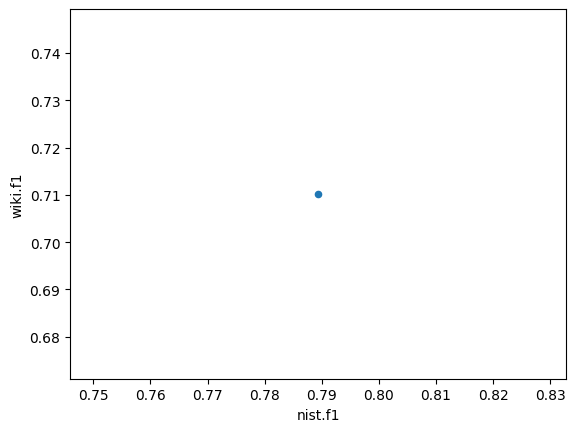

In [29]:
by_run_df[["nist.f1", "wiki.f1"]].plot.scatter(x="nist.f1", y="wiki.f1")

<Axes: ylabel='run'>

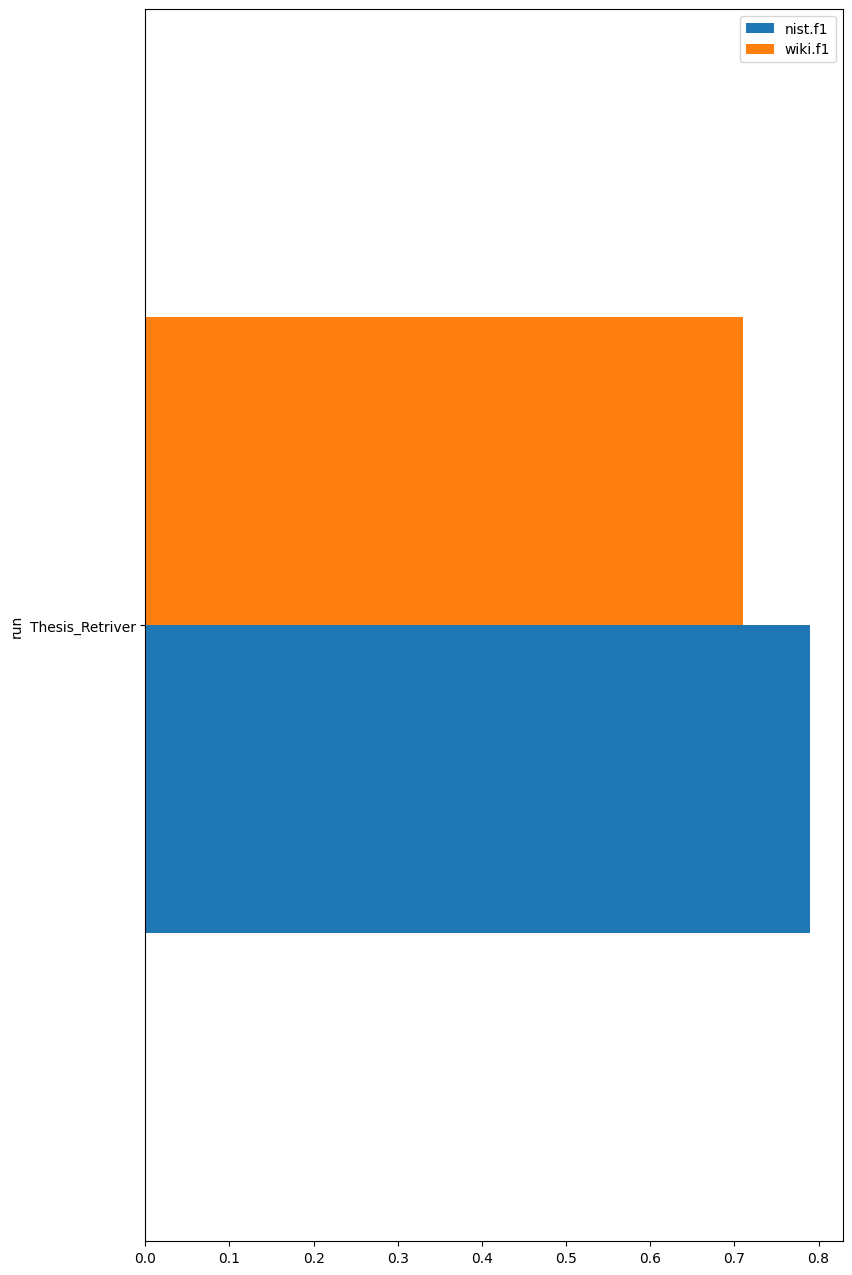

In [30]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_run_df[["nist.f1", "wiki.f1"]].sort_values(by="nist.f1").plot.barh(ax=ax)

## By Day

In [31]:
rows = []
for event,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("event"):
    print(event)
    t_map = {"event": event}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)

CrisisFACTS-010
	 nist
		 f1 0.7420228123664856
		 precision 0.7173117995262146
		 recall 0.7684972286224365
	 wiki
		 f1 0.6787211894989014
		 precision 0.6466333270072937
		 recall 0.7141598463058472
CrisisFACTS-011
	 nist
		 f1 0.7791064381599426
		 precision 0.7866237759590149
		 recall 0.7717314958572388
	 wiki
CrisisFACTS-015
	 nist
		 f1 0.7907036542892456
		 precision 0.8017104268074036
		 recall 0.7799950838088989
	 wiki
		 f1 0.7502999901771545
		 precision 0.7294612526893616
		 recall 0.7723643779754639
CrisisFACTS-017
	 nist
		 f1 0.8036996126174927
		 precision 0.784863293170929
		 recall 0.8234622478485107
	 wiki
		 f1 0.6830912828445435
		 precision 0.6329562664031982
		 recall 0.7418516874313354
CrisisFACTS-018
	 nist
		 f1 0.83127361536026
		 precision 0.8308707475662231
		 recall 0.8316768407821655
	 wiki
		 f1 0.7286422848701477
		 precision 0.688754677772522
		 recall 0.7734339833259583


In [32]:
by_event_df = pd.DataFrame(rows).set_index("event")
by_event_df.to_csv("by_event.bertscore.summary.csv")
by_event_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
event,,
CrisisFACTS-010,0.742023,0.678721
CrisisFACTS-011,0.779106,NaN
CrisisFACTS-015,0.790704,0.750300
CrisisFACTS-017,0.803700,0.683091
CrisisFACTS-018,0.831274,0.728642


<Axes: ylabel='event'>

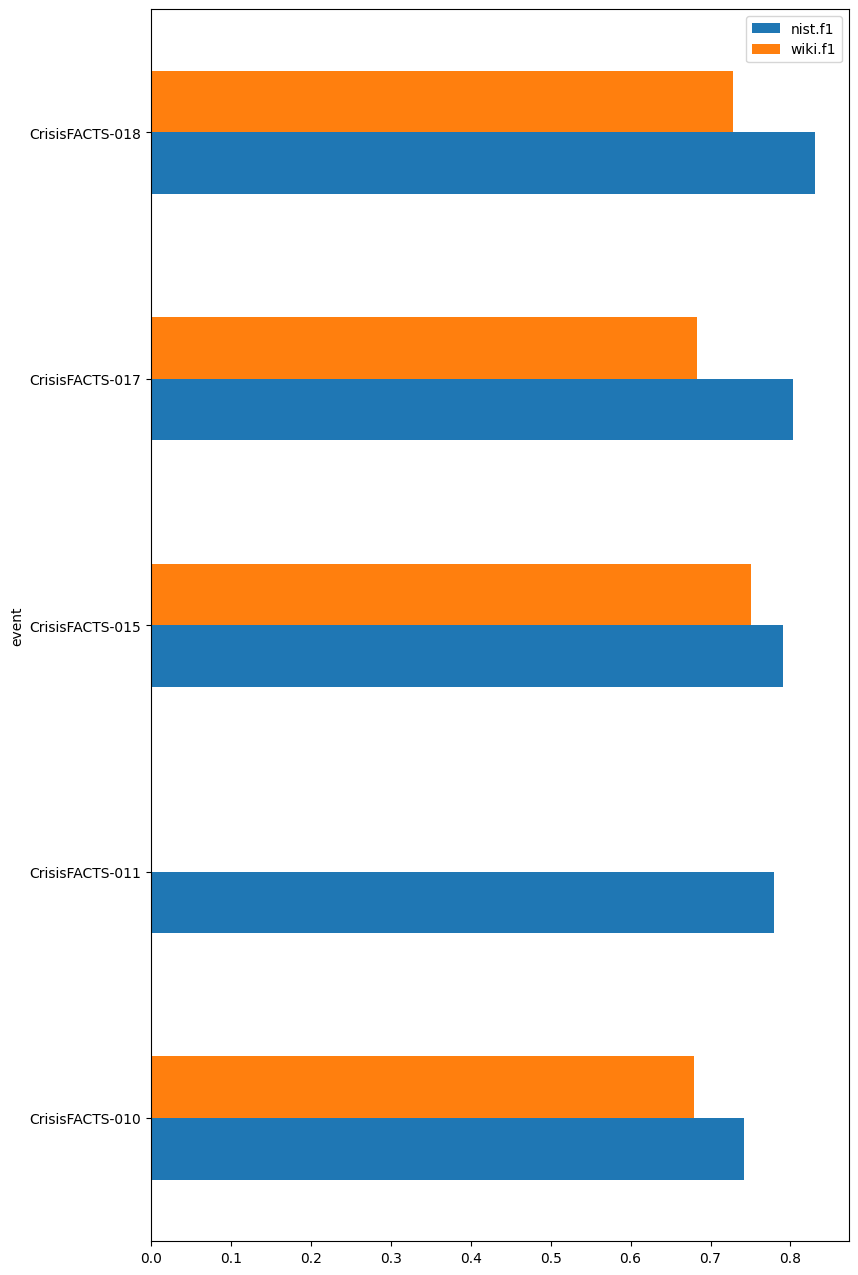

In [33]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_event_df[["nist.f1", "wiki.f1"]].plot.barh(ax=ax)

In [34]:
score_df = pd.read_csv("by_event.bertscore.summary.csv", index_col=0)
print(score_df.groupby("event").mean().style.to_latex())

\begin{tabular}{lrrrrrr}
 & nist.f1 & nist.precision & nist.recall & wiki.f1 & wiki.precision & wiki.recall \\
event &  &  &  &  &  &  \\
CrisisFACTS-010 & 0.742023 & 0.717312 & 0.768497 & 0.678721 & 0.646633 & 0.714160 \\
CrisisFACTS-011 & 0.779106 & 0.786624 & 0.771731 & nan & nan & nan \\
CrisisFACTS-015 & 0.790704 & 0.801710 & 0.779995 & 0.750300 & 0.729461 & 0.772364 \\
CrisisFACTS-017 & 0.803700 & 0.784863 & 0.823462 & 0.683091 & 0.632956 & 0.741852 \\
CrisisFACTS-018 & 0.831274 & 0.830871 & 0.831677 & 0.728642 & 0.688755 & 0.773434 \\
\end{tabular}



In [35]:
print(score_df.groupby("event").mean().style.to_latex())

\begin{tabular}{lrrrrrr}
 & nist.f1 & nist.precision & nist.recall & wiki.f1 & wiki.precision & wiki.recall \\
event &  &  &  &  &  &  \\
CrisisFACTS-010 & 0.742023 & 0.717312 & 0.768497 & 0.678721 & 0.646633 & 0.714160 \\
CrisisFACTS-011 & 0.779106 & 0.786624 & 0.771731 & nan & nan & nan \\
CrisisFACTS-015 & 0.790704 & 0.801710 & 0.779995 & 0.750300 & 0.729461 & 0.772364 \\
CrisisFACTS-017 & 0.803700 & 0.784863 & 0.823462 & 0.683091 & 0.632956 & 0.741852 \\
CrisisFACTS-018 & 0.831274 & 0.830871 & 0.831677 & 0.728642 & 0.688755 & 0.773434 \\
\end{tabular}

